![](../img/330-banner.png)

# Lecture 3: Machine Learning Fundamentals 

UBC 2025-26

## Imports, LOs

### Imports

In [1]:
# import the libraries
import os
import sys

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from sklearn.model_selection import train_test_split

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
from plotting_functions import *

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from utils import *

%matplotlib inline

pd.set_option("display.max_colwidth", 200)
plt.rcParams["font.size"] = 16

DATA_DIR = '../data/'

import warnings
warnings.filterwarnings('ignore')

<br><br>

### Learning outcomes

From this lecture, you will be able to 

- explain how decision boundaries change with the `max_depth` hyperparameter;
- explain the concept of generalization;
- appropriately split a dataset into train and test sets using `train_test_split` function;
- explain the difference between train, validation, test, and "deployment" data;
- identify the difference between training error, validation error, and test error;
- explain cross-validation and use `cross_val_score` and `cross_validate` to calculate cross-validation error;
- recognize overfitting and/or underfitting by looking at train and test scores;
- explain why it is generally not possible to get a perfect test score (zero test error) on a supervised learning problem;
- describe the fundamental tradeoff between training score and the train-test gap;
- state the golden rule;
- start to build a standard recipe for supervised learning: train/test split, hyperparameter tuning with cross-validation, test on test set.

This is a modified version of the notes available [here](https://github.com/UBC-CS/cpsc330-2025W1/blob/main/lectures/notes/03_ml-fundamentals.ipynb). Always refer to the notes as the complete source of material.

<br><br><br><br>

## Generalization [[video](https://youtu.be/iS2hsRRlc2M)]

### Big picture and motivation 

In machine learning we want to learn a mapping function from labeled data so that we can predict labels of **unlabeled** data. For example, suppose we want to build a spam filtering system.  We will take a large number of spam/non-spam messages from the past, learn patterns associated with spam/non-spam from them, and predict whether **a new incoming message** in someone's inbox is spam or non-spam based on these patterns. 

So we want to learn from the past but ultimately we want to apply it on the future email messages. 

### Model complexity and training error

In the last lecture, we looked at decision boundaries, a way to visualize what sort of examples will be classified as positive and negative. 

Let's examine how does the decision boundary change for different tree depths. 

In [2]:
# Toy quiz2 grade data
classification_df = pd.read_csv(DATA_DIR + "quiz2-grade-toy-classification.csv")
classification_df.head(10)

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+
5,1,0,70,73,68,74,71,not A+
6,1,0,80,88,89,88,91,A+
7,0,1,95,93,69,79,75,not A+
8,0,0,97,90,94,99,80,not A+
9,1,1,95,95,94,94,85,not A+


In [3]:
X = classification_df.drop(["quiz2"], axis=1)
y = classification_df["quiz2"]

In [4]:
X_subset = X[["lab4", "quiz1"]]  # Let's consider a subset of the data for visualization
X_subset.head()

,lab4,quiz1
0,91,92
1,83,91
2,80,80
3,91,89
4,92,85


In the following model, this decision boundary is created by asking one question. 

Error:   0.286


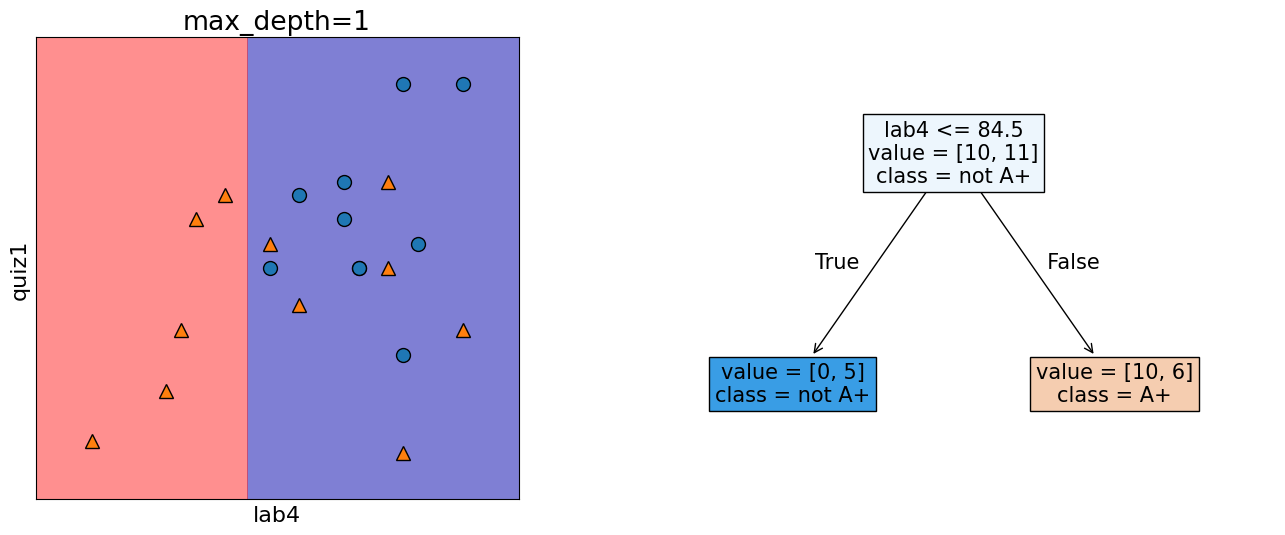

In [5]:
depth = 1
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset.values, y)
model.score(X_subset.values, y)
print("Error:   %0.3f" % (1 - model.score(X_subset.values, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1", fontsize=15
)

In the following model, this decision boundary is created by asking two questions. 

Error:   0.190


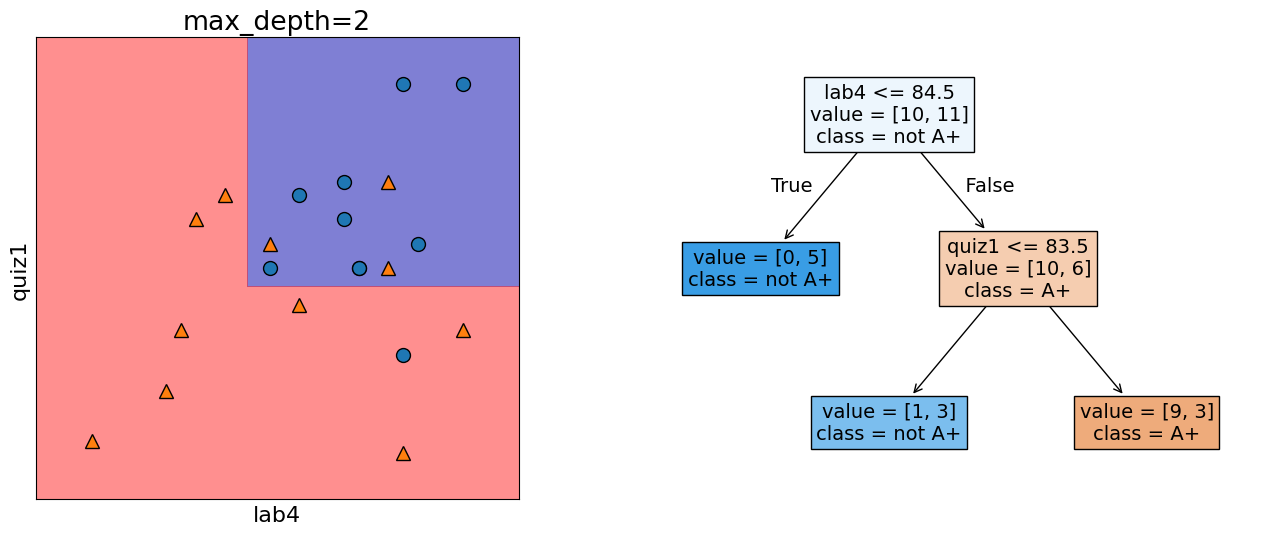

In [6]:
depth = 2
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset.values, y)
model.score(X_subset.values, y)
print("Error:   %0.3f" % (1 - model.score(X_subset.values, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1", fontsize=14
)

Let's look at the decision boundary with depth = 4. 

Error:   0.048


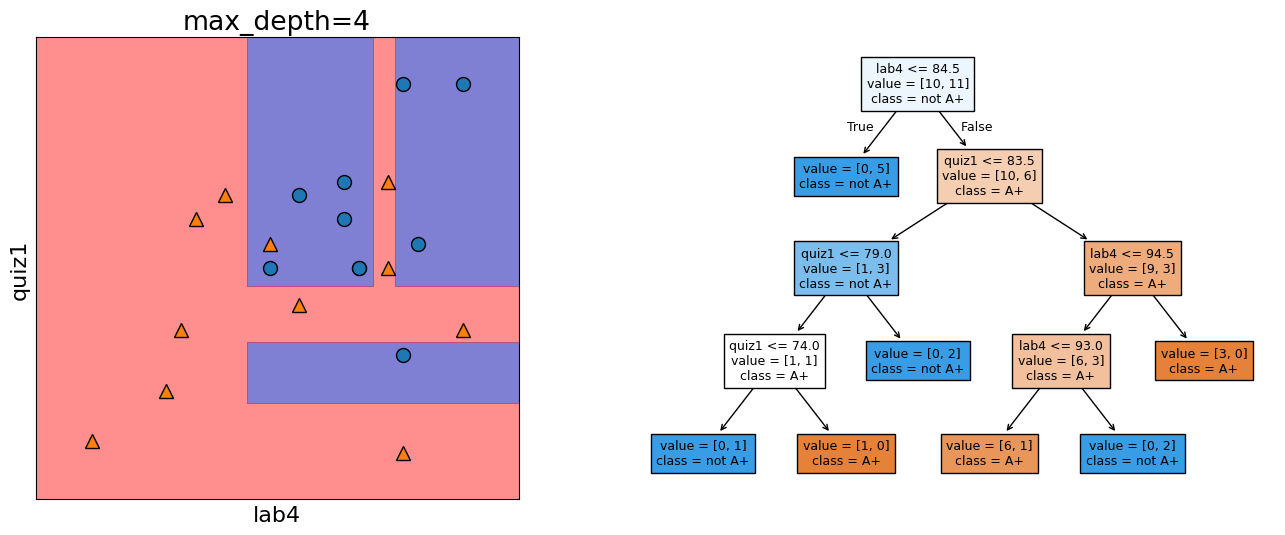

In [7]:
depth = 4
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset.values, y)
model.score(X_subset.values, y)
print("Error:   %0.3f" % (1 - model.score(X_subset.values, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

Let's look at the decision boundary with depth = 6. 

Error:   0.000


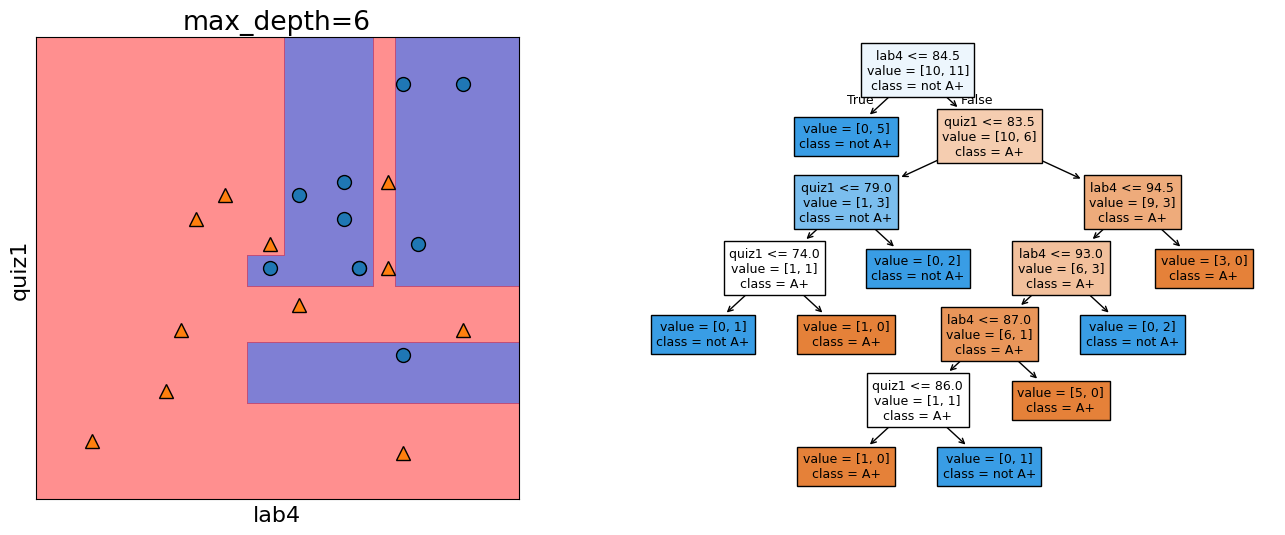

In [8]:
depth = 6
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

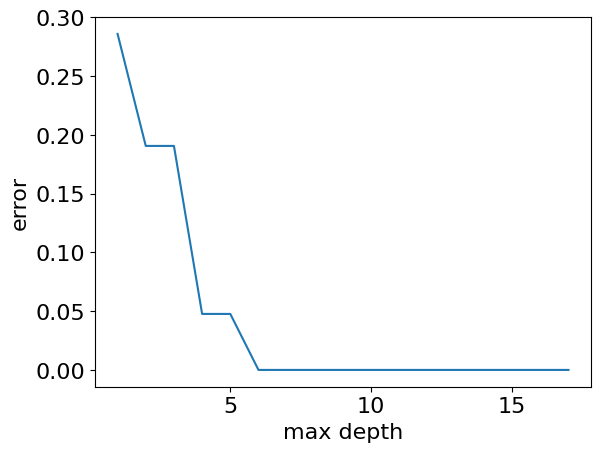

In [9]:
max_depths = np.arange(1, 18)
errors = []
for max_depth in max_depths:
    error = 1 - DecisionTreeClassifier(max_depth=max_depth).fit(X_subset, y).score(
        X_subset, y
    )
    errors.append(error)
plt.plot(max_depths, errors)
plt.xlabel("max depth")
plt.ylabel("error");

- Our model has 0% error for depths >= 6!! 
- But it's also becoming more and more specific and sensitive to the training data.  
- Is it good or bad?
- What is the best depth?

### Generalization: Fundamental goal of ML

> **To generalize beyond what we see in the training examples**

We only have access to limited amount of training data and we want to learn a mapping function which would predict targets reasonably well for examples beyond this training data. 

### Training error vs. Generalization error 

- Given a model $M$, in ML, people usually talk about two kinds of errors of $M$. 
    1. Error on the training data: $error_{training}(M)$ 
    2. Error on the entire distribution $D$ of data: $error_{D}(M)$
- We are interested in the error on the entire distribution     
    - ... But we do not have access to the entire distribution 😞

## Demo

Let's start practicing these ideas on a new dataset. We will use the King County housing sale prediction data from the course introduction video. You can download the data from [here](https://www.kaggle.com/harlfoxem/housesalesprediction). 

In [10]:
housing_df = pd.read_csv(DATA_DIR + 'kc_house_data.csv')
housing_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


## Exploratory Data Analysis

Is this a classification problem or a regression problem? 

In [11]:
# How many data points do we have? 
housing_df.shape[0]

21613

In [12]:
# What are the columns in the dataset? 
housing_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Let's explore some features. Let's try the `describe()` method

In [13]:
housing_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Do we need to keep all the columns? 

In [14]:
housing_df['id'].unique().shape[0]

21436

In [15]:
housing_df['zipcode'].value_counts()

zipcode
98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: count, Length: 70, dtype: int64

In [16]:
dates = pd.to_datetime(['20141013T000000', '20141209T000000', '20150218T000000'], format='%Y%m%dT%H%M%S')
dates.month_name()

Index(['October', 'December', 'February'], dtype='object')

In [17]:
# What are the value counts of the `waterfront` feature? 
housing_df['waterfront'].value_counts()

waterfront
0    21450
1      163
Name: count, dtype: int64

In [18]:
# What are the value_counts of `yr_renovated` feature? 
housing_df['yr_renovated'].value_counts()

yr_renovated
0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1948        1
1951        1
1959        1
1934        1
1944        1
Name: count, Length: 70, dtype: int64

Many opportunities to clean the data but we'll stop here. 

Let's create `X` and `y`. 

In [19]:
X = housing_df.drop(columns = ['id', 'date', 'zipcode', 'price'])

In [20]:
y = housing_df['price']

<br><br>

## Baseline model 

In [21]:
# Train a DummyRegressor model 

from sklearn.dummy import DummyRegressor # Import DummyRegressor 

# Create a class object for the sklearn model.
dummy_regr = DummyRegressor()

# fit the dummy regressor
dummy_regr.fit(X,y)

# score the model 
dummy_regr.score(X,y)


0.0

<br><br>

## Decision tree model 

In [22]:
# Train a decision tree model 

from sklearn.tree import DecisionTreeRegressor # Import DecisionTreeRegressor 

# Create a class object for the sklearn model.
dt_regr = DecisionTreeRegressor(random_state=123)


# fit the decision tree regressor 
dt_regr.fit(X,y)

# score the model 
dt_regr.score(X,y)

0.9991338290544213

We are getting an almost perfect score. Should we be happy with this model and deploy it? Why or why not?

What's the depth of this model? 

In [23]:
dt_regr.get_depth()

38

## Data Splitting [[video](https://youtu.be/h2AEobwcUQw)]

### How to approximate generalization error? 

A common way is **data splitting**. 
- Keep aside some randomly selected portion from the training data.
- `fit` (train) a model on the training portion only. 
- `score` (assess) the trained model on this set aside data to get a sense of how well the model would be able to generalize.
- Pretend that the kept aside data is representative of the real distribution $D$ of data. 

![](../img/eva-good-idea.png)

In [24]:
# scikit-learn train_test_split
url = "https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"
HTML("<iframe src=%s width=1000 height=800></iframe>" % url)

- We can pass `X` and `y` or a dataframe with both `X` and `y` in it. 
- We can also specify the train or test split sizes. 

### Simple train/test split 

- The picture shows an 80%-20% split of a toy dataset with 10 examples. 
- There is no hard and fast rule on what split sizes should we use. Some common splits are 90/10, 80/20, 70/30 (training/test).
- The data is shuffled before splitting. 
- Usually when we do machine learning we split the data before doing anything and put the test data in an imaginary chest lock. 

![](../img/train-test-split.png)

<!-- <img src='img/train-test-split.png' width="1500" height="1500" /> -->

In [25]:
# Split the data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [26]:
# Instantiate a class object 
dt = DecisionTreeRegressor(random_state=123)

# Train a decision tree on X_train, y_train
dt.fit(X_train, y_train)

# Score on the train set
dt.score(X_train, y_train)


0.9994394006711425

In [27]:
# Score on the test set
dt.score(X_test, y_test)


0.719915905190645

### Activity: Discuss the following questions in your group

- Why is there a large gap between train and test scores? 
- What would be the effect of increasing or decreasing `test_size`?
- Why are we setting the `random_state`? Is it a good idea to try a bunch of values for the `random_state` and pick the one which gives the best scores? 
- Would it be possible to further improve the scores? 

## Hyperparameter optimization 

Let's try out different tree depths. 

In [28]:
# max_depth= 1 
dt = DecisionTreeRegressor(max_depth=1, random_state=123) 
dt.fit(X_train, y_train)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",1
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",123
,"max_lea

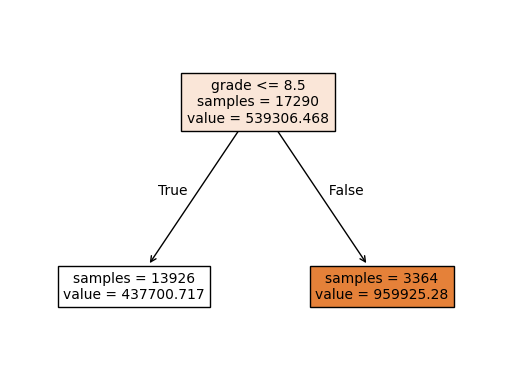

In [29]:
# Visualize your decision stump
from sklearn.tree import plot_tree 
plot_tree(dt, feature_names = X.columns.tolist(), impurity=False, filled=True, fontsize=10);

In [30]:
dt.score(X_train, y_train) # Score on the train set

0.3209427041566191

In [31]:
dt.score(X_test, y_test) # Score on the test set

0.31767136668453344

- How do these scores compare to the previous scores? 

Let's try depth 10. 

In [32]:
dt = DecisionTreeRegressor(max_depth=10, random_state=123) # max_depth= 10 
dt.fit(X_train, y_train)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",123
,"max_le

In [33]:
dt.score(X_train, y_train) # Score on the train set

0.9108334653214172

In [34]:
dt.score(X_test, y_test) # Score on the test set

0.7728396574320712

- Any improvements? Which depth should we pick? 
- Am I doing something wrong with the way I am handling my datasets?

### Train/validation/test split

- Some of you may have heard of "validation" data.
- Sometimes it's a good idea to have a separate data for hyperparameter tuning. 

<!-- ![](../img/train-valid-test-split.png) -->

<img src='../img/train-valid-test-split.png' width="800" />

- We will try to use "validation" to refer to data where we have access to the target values.
  - But, unlike the training data, we only use this for hyperparameter tuning and model assessment; we don't pass these into `fit`.  
- We will try to use "test" to refer to data where we have access to the target values 
  - But, unlike training and validation data, we neither use it in training nor hyperparameter optimization.
  - We only use it **once** to evaluate the performance of the best performing model on the validation set.   
  - We lock it in a "vault" until we're ready to evaluate. 

### Why does it matter

- Test data is supposed to be the closest thing to real world, completely unseen samples.
- It should not influence the model in any way, not even in the choice of hyperparameters.

### "Deployment" data

- After we build and finalize a model, we deploy it, and then the model deals with the data in the wild. 
- We will use "deployment" to refer to this data, where we do **not** have access to the target values.
- Deployment error is what we _really_ care about.
- We use validation and test errors as proxies for deployment error, and we hope they are similar.
- So, if our model does well on the validation and test data, we hope it will do well on deployment data.

### Summary of train, validation, test, and deployment data

|         | `fit` | `score` | `predict` |
|----------|-------|---------|-----------|
| Train    | ✔️      | ✔️      | ✔️         |
| Validation |      | ✔️      | ✔️         |
| Test    |       |  once   | once         |
| Deployment    |       |       | ✔️         |

You can typically expect $E_{train} < E_{validation} < E_{test} < E_{deployment}$.

Let's try this idea on the regression problem: we will create a validation set to pick the right depth and assess the final model on the test set. 

In [35]:
# Create a validation set 
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [36]:
tr_scores = []
valid_scores = []
depths = np.arange(1, 35, 2)

for depth in depths:  
    # Create and fit a decision tree model for the given depth  
    dt = DecisionTreeRegressor(max_depth=depth, random_state=123)

    dt.fit(X_tr, y_tr)
    # Calculate and append r2 scores on the training and validation sets
    tr_scores.append(dt.score(X_tr, y_tr))    
    valid_scores.append(dt.score(X_valid, y_valid))
    
results_single_valid_df = pd.DataFrame({"train_score": tr_scores, 
                           "valid_score": valid_scores},index = depths)
results_single_valid_df

,train_score,valid_score
1,0.319559,0.326616
3,0.603739,0.555180
5,0.754938,0.677567
7,0.833913,0.737285
9,0.890456,0.763480
11,0.931896,0.790521
13,0.963024,0.769030
15,0.981643,0.752728
17,0.991810,0.735637
19,0.996424,0.745925


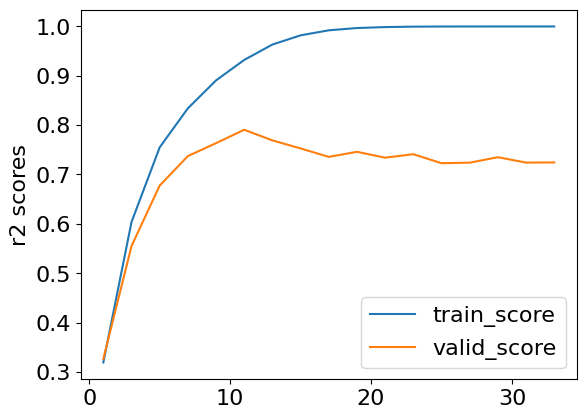

In [37]:
results_single_valid_df[['train_score', 'valid_score']].plot(ylabel='r2 scores');

What depth gives the "best" validation score? 

In [38]:
# What depth gives the "best" validation score?
best_depth = results_single_valid_df['valid_score'].idxmax() 
best_depth

np.int64(11)

## ❓❓ Questions for you

### iClicker Exercise 3.1

**Select all of the following statements which are TRUE.**

- (A) A decision tree model with no depth (the default `max_depth` in `sklearn`) is likely to perform very well on the deployment data. 
- (B) Data splitting helps us assess how well our model would generalize. 
- (C) Deployment data is only scored once.  
- (D) Validation data could be used for hyperparameter optimization. 
- (E) It's recommended that data be shuffled before splitting it into `train` and `test` sets..


<br><br><br><br>

## Break (5 min)

![](../img/eva-coffee.png)


## Cross-validation [[video](https://youtu.be/4cv8VYonepA)]

### Problems with single train/validation split

- Only using a portion of your data for training and only a portion for validation.
- If your dataset is small you might end up with a tiny training and/or validation set.
- You might be unlucky with your splits such that they don't align well or don't well represent your test data.
- **Low reliability of validation score.**

<!-- ![](../img/train-valid-test-split.png) -->

<img src='../img/train-valid-test-split.png' height="800" />

### Cross-validation to the rescue!! 

- Cross-validation provides a solution to this problem. 
- Split the data into $k$ folds ($k>2$, often $k=10$). In the picture below $k=4$.
- Each "fold" gets a turn at being the validation set.
- Note that cross-validation doesn't shuffle the data; it's done in `train_test_split`.

<!-- ![](../img/cross-validation.png) -->
<img src='../img/cross-validation.png' height="800" />

- Each fold gives a score and we usually average our $k$ results. 
- It's better to examine the variation in the scores across folds.  
- Gives a more **robust** measure of error on unseen data.

### Cross-validation using `scikit-learn` on housing data

Let's start by using the `cross_val_score` function on a particular instance of our Decision Tree model (depth = 9)

In [39]:
from sklearn.model_selection import cross_val_score, cross_validate

In [40]:
dt = DecisionTreeRegressor(max_depth=9, random_state=123)
cv_scores = cross_val_score(dt, X_train, y_train, cv=10)
cv_scores

array([0.72322046, 0.78176915, 0.68517546, 0.79598528, 0.8044116 ,
       0.78792657, 0.80495534, 0.75490599, 0.81229831, 0.76934947])

In [41]:
print(f"Average cross-validation score = {np.mean(cv_scores):.2f}")
print(f"Standard deviation of cross-validation score = {np.std(cv_scores):.2f}")

Average cross-validation score = 0.77
Standard deviation of cross-validation score = 0.04


Under the hood

- It creates `cv` **folds** on the data.
- In each fold, it **fits** the model on the **training** portion and **scores** on the **validation** portion. 
- The output is a list of **validation scores** in each fold.

If we used only one validation set, we could have gotten any of these scores!

#### `cross_validate`

- Similar to `cross_val_score` but more powerful.
- Gives us access to **training and validation scores**.  

In [42]:
scores = cross_validate(dt, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.162737,0.002444,0.723220,0.894828
1,0.155957,0.003095,0.781769,0.893915
2,0.150842,0.002446,0.685175,0.891224
3,0.156103,0.002256,0.795985,0.892983
4,0.142127,0.002295,0.804412,0.890107
5,0.146602,0.002419,0.787927,0.887772
6,0.141234,0.002026,0.804955,0.891174
7,0.141269,0.002981,0.754906,0.890201
8,0.146349,0.002454,0.812298,0.888645
9,0.143489,0.002913,0.769349,0.891384


In [43]:
pd.DataFrame(pd.DataFrame(scores).mean())

,0
fit_time,0.148671
score_time,0.002533
test_score,0.772000
train_score,0.891223


Cross-validation increases our confidence in the validation score. Now that we have this tool, we can use it for hyperparameter tuning.

In [44]:
depths = np.arange(1, 35, 2)

cv_train_scores = []
cv_valid_scores = []
for depth in depths: 
    # Create and fit a decision tree model for the given depth   
    dt = DecisionTreeRegressor(max_depth = depth, random_state=123)

    # Carry out cross-validation
    results = cross_validate(dt, X_train, y_train, cv=5, return_train_score=True)
    cv_train_scores.append(results['train_score'].mean())
    cv_valid_scores.append(results['test_score'].mean())    

In [45]:
results_df = pd.DataFrame({"train_score": cv_train_scores, 
                           "valid_score": cv_valid_scores},
                           index=depths)

results_df

,train_score,valid_score
1,0.321050,0.322465
3,0.603243,0.559284
5,0.752169,0.688484
7,0.835876,0.758259
9,0.894960,0.768184
11,0.938201,0.772185
13,0.966812,0.760966
15,0.983340,0.754620
17,0.992220,0.730025
19,0.996487,0.722803


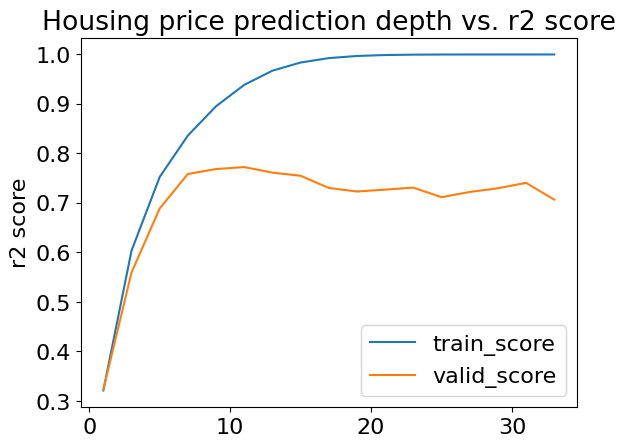

In [46]:
results_df[['train_score', 'valid_score']].plot(ylabel='r2 score', title='Housing price prediction depth vs. r2 score');

What's the "best" depth with cross-validation? 

In [47]:
best_depth = results_df['valid_score'].idxmax()
best_depth

np.int64(11)

### Discuss the following questions in your group

1. At which depth(s) are we **underfitting**? At which depth(s) are we **overfitting**?
2. Above, we chose the depth that gives us the best cross-validation score. Is it always a good idea to select this depth? What if a simpler model with a smaller max_depth gives nearly the same cross-validation score?
3. If our main concern is test scores, why don't we use the test set during training?

### More details

Keep in mind that cross-validation does not return a model. It is not a way to build a model that can be applied to new data. The purpose of cross-validation is to **evaluate** how well the model will generalize to unseen data. 

Note that both `cross_val_score` and `cross_validate` functions do not shuffle the data. Check out [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), where proportions of classes is the same in each fold as they are in the whole dataset. By default, `sklearn` uses `StratifiedKFold` when carrying out cross-validation for classification problems. 

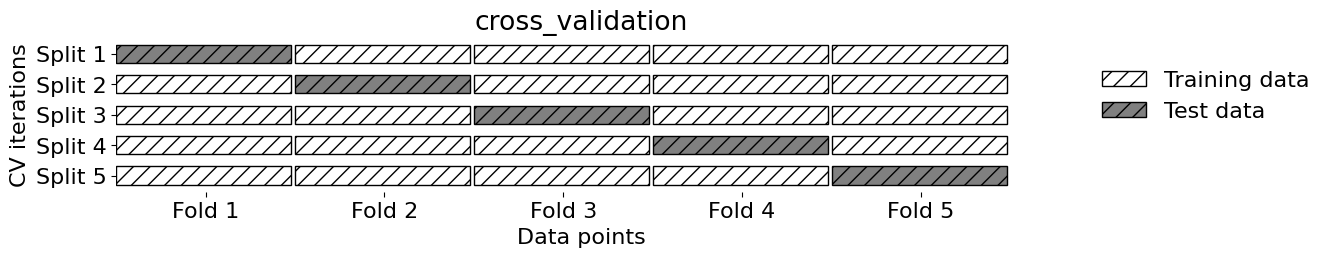

In [48]:
mglearn.plots.plot_cross_validation()

```{admonition} Exercise 3.3: Cross-validation

```

## Underfitting, overfitting, the fundamental trade-off, the golden rule [[video](https://youtu.be/Ihay8yE5KTI)]

### Types of errors

We're going to think about 4 types of errors:

- $E_\textrm{train}$ is your training error (or mean train error from cross-validation).
- $E_\textrm{valid}$ is your validation error (or mean validation error from cross-validation).
- $E_\textrm{test}$ is your test error.
- $E_\textrm{best}$ is the best possible error you could get for a given problem.

The relative values of these errors tell you a lot about how the model is learning.

### Underfitting 

- If your model is too simple, like `DummyClassifier` or `DecisionTreeClassifier` with `max_depth=1`, it's not going to pick up on some random quirks in the data but it won't even capture useful patterns in the training data.
- The model won't be very good in general. Both train and validation errors would be high. This is **underfitting**.
- The gap between train and validation error is going to be lower (same is true for accuracy and R<sup>2</sup> scores).
- $E_\textrm{best} \lt E_\textrm{train} \lesssim E_\textrm{valid}$

### Overfitting 

- If your model is very complex, like a `DecisionTreeClassifier(max_depth=None)`, then you will learn unreliable patterns in order to get every single training example correct.
- The training error is going to be very low but there will be a big gap between the training error and the validation error. This is **overfitting**.
- In overfitting scenario, usually we'll see: 
$E_\textrm{train} \lt E_\textrm{best}  \lt E_\textrm{valid}$
- In general, if $E_\textrm{train}$ is low, we are likely to be in the overfitting scenario. It is fairly common to have at least a bit of this.

In other words, the validation error does not necessarily decrease with the training error. 

### The "fundamental tradeoff" of supervised learning:


**As you increase model complexity, $E_\textrm{train}$ tends to go down but $E_\textrm{valid}-E_\textrm{train}$ tends to go up.**


### Bias vs variance tradeoff 

- The fundamental trade-off is also called the bias/variance tradeoff in supervised machine learning.

**Bias**
: the tendency to consistently **learn the same thing** (high bias corresponds to underfitting). Typical of **simple models**.

**Variance** 
: the tendency to **learn random things** irrespective of the real signal (high variance corresponds to overfitting). Typical of **very complex models**.

<img src='../img/overfitting_underfitting.png' width="600" />

### How to pick a model that would generalize better?

- We want to avoid both underfitting and overfitting. 
- We want to be consistent with the training data but we don't want to rely too much on it. 

<!-- <center>
<img src='img/malp_0201.png' width="800" height="800" />
</center>    
 -->
<img src='../img/malp_0201.png' width="600" />
<!-- ![](../img/malp_0201.png) -->

[source](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch02.html#relation-of-model-complexity-to-dataset-size)

- There are many subtleties here and there is no perfect answer but a  common practice is to pick the model with minimum cross-validation error. 

### The golden rule <a name="4"></a>

- Even though we care the most about test error **THE TEST DATA CANNOT INFLUENCE THE TRAINING PHASE IN ANY WAY**. 
- We have to be very careful not to violate it while developing our ML pipeline. 
- Even experts end up breaking it sometimes which leads to misleading results and lack of generalization on the real data. 

![](../img/golden_rule_violation.png)

<!-- <center>
<img src='img/golden_rule_violation.png' width="500" height="500" />
</center>    
 -->
 
<blockquote>
   ... He attempted to reproduce the research, and found a major flaw: there was some overlap in the data used to both train and test the model. 
</blockquote>    

### How can we avoid violating golden rule? 

- Recall that when we split data, we put our test set in an imaginary vault.

<!-- <center>
<img src='img/train-test-split.png' width="1500" height="1500" />
</center>    
 -->
 
<img src='../img/train-test-split.png' width="800" />
![](../img/train-test-split.png)

### Here is the workflow we'll generally follow. 

- **Splitting**: Before doing anything, split the data `X` and `y` into `X_train`, `X_test`, `y_train`, `y_test` or `train_df` and `test_df` using `train_test_split`. 
- **Select the best model using cross-validation**: Use `cross_validate` with `return_train_score = True` so that we can get access to training scores in each fold. (If we want to plot train vs validation error plots, for instance.) 
- **Scoring on test data**: Finally score on the test data with the chosen hyperparameters to examine the generalization performance.

**Again, there are many subtleties here; we'll discuss the golden rule multiple times throughout the course.**  

Going back to our regression problem, this is the score we would report as model performance:

In [49]:
# Train a model with the best depth of the full training data
dt_final = DecisionTreeRegressor(max_depth=best_depth, random_state=123)
dt_final.fit(X_train, y_train)

# Score on the test set to assess deployment performance
dt_final.score(X_test, y_test)

0.7784948928666875

<br><br><br><br>

## ❓❓ Questions for you

### iClicker Exercise 3.2 

**Select all of the following statements which are TRUE.**

- (A) $k$-fold cross-validation calls fit $k$ times.
- (B) We use cross-validation to get the best hyperparameters for our model.
- (C) If the mean train accuracy is much higher than the mean cross-validation accuracy it's likely to be a case of overfitting.
- (D) The fundamental tradeoff of ML states that as training error goes down, validation error goes up.
- (E) When doing 10-fold CV on a Decision Tree of depth 1, the resulting trees will be more similar to each other than when doing 10-fold CV on a Decision Tree of depth 5.


<br><br>

## Summary and reflection

### What did we learn today?

- Importance of generalization in supervised machine learning 
- Data splitting as a way to approximate generalization error 
- Train, test, validation, deployment data
- Cross-validation
- A typical sequence of steps to train supervised machine learning models
    - training the model on the train split
    - tuning hyperparamters using the validation split
    - checking the generalization performance on the test split 
- Overfitting, underfitting, the fundamental tradeoff, and the golden rule.   

### Coming up ...  

- KNNs, SVM RBFs 
- Preprocessing
    - Imputation
    - Scaling
    - One-hot encoding
    - `sklearn` pipelines

![](../img/eva-seeyou.png)